# Itération 7

In [25]:
import os
import psycopg2
from dotenv import load_dotenv

import pandas as pd
import numpy as np

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn')

# Affichage cellule
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_row', 1000)
from pprint import pprint

# Chargement du model pour déploiement
import pickle

In [26]:


load_dotenv()  # Nécessaire pour charger les variables d'environnement précédemment définies

# Créer une connexion à postgres
connection = psycopg2.connect(host=os.environ.get('PG_HOST'),
                        user=os.environ.get('PG_USER'),
                        password=os.environ.get('PG_PASSWORD'),
                        dbname=os.environ.get('PG_DATABASE'))

connection.autocommit = True  # Assurez-vous que les données sont ajoutées à la base de données immédiatement après les commandes d'écriture.
cursor = connection.cursor()
cursor.execute('SELECT %s as connected;', ('Connection à postgres Réussie!',))
print(cursor.fetchone())

('Connection à postgres Réussie!',)


In [27]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Transformer une requête SELECT en un dataframe pandas
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturellement, nous obtenons une liste de "tupples".
    tupples = cursor.fetchall()
    cursor.close()
    
    # Nous devons juste le transformer en dataframe pandas.
    df = pd.DataFrame(tupples, columns=column_names)
    return df

In [28]:
conn = connection
column_names = ["user_id","gender", "age", "height", "weight", "duration", "heart_rate", "body_temp", "calorie"]
# Execute the "SELECT *" query
df_db = postgresql_to_dataframe(conn, 
"SELECT persons.user_id as id, gender, age, height, weight, duration, heart_rate, body_temp,calorie FROM calories INNER JOIN persons ON calories.user_id = persons.user_id"
                                , column_names)
df_db.head(2)

,user_id,gender,age,height,weight,duration,heart_rate,body_temp,calorie
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0


In [29]:
#data_non_scalé = df_db.drop(columns=['gender'])

In [30]:
data = df_db.copy()

# ITERATION 1

In [31]:
# encodage en one hot et mormalisation des données avec min max scaler avec column transformer

ohe=OneHotEncoder(sparse=False)
#scaler = MinMaxScaler()
scaler = StandardScaler()

ct=make_column_transformer((ohe,['gender']),
                      (scaler,  ['age', 'height', 'weight', 'duration', 'heart_rate', 'body_temp','calorie']),remainder='passthrough')
data_ct=ct.fit_transform(data)

# Encodage sur le genre et retransformation en dataframe pandas nommé dum
ohe_True=OneHotEncoder(sparse=True)
ohe_with_sparse=ohe_True.fit_transform(data['gender'].values.reshape(-1,1)).toarray()
ohe_with_sparse

dum_scaler=pd.get_dummies(data,columns=['gender'],prefix='',prefix_sep='')

In [32]:
data = dum_scaler.copy()

In [33]:
data = data.drop(columns=['user_id'], axis=1)

In [34]:
X = data.drop(columns=['calorie'], axis=1)
X.head(1)

,age,height,weight,duration,heart_rate,body_temp,female,male
0,68,190.0,94.0,29.0,105.0,40.8,0,1


In [35]:
y = data.calorie
y.head(1)

0    231.0
Name: calorie, dtype: float64

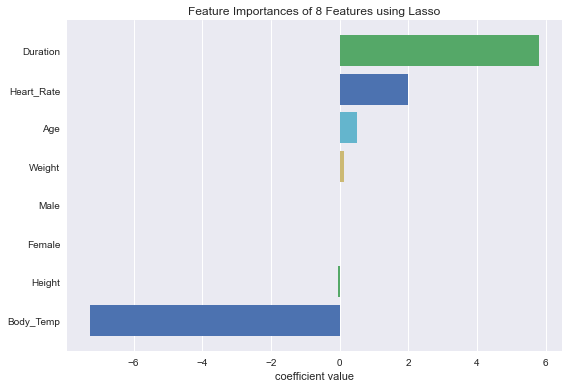

<AxesSubplot:title={'center':'Feature Importances of 8 Features using Lasso'}, xlabel='coefficient value'>

In [36]:
from sklearn.linear_model import Lasso
from yellowbrick.model_selection import FeatureImportances

labels =list(map(lambda s: s.title(), X))
viz = FeatureImportances(Lasso(), labels=labels, relative=False)

# Fit and show the feature importances
viz.fit(X, y)
viz.show()

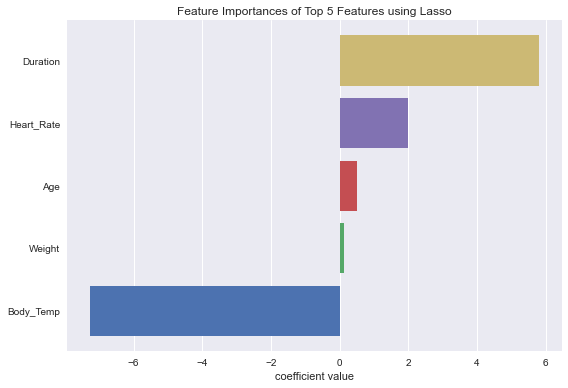

<AxesSubplot:title={'center':'Feature Importances of Top 5 Features using Lasso'}, xlabel='coefficient value'>

In [37]:
from sklearn.linear_model import Lasso
from yellowbrick.datasets import load_concrete
from yellowbrick.model_selection import FeatureImportances

# Load the regression dataset
dataset = load_concrete(return_dataset=True)
X = data.drop(columns=['calorie'], axis=1)
y = data.calorie

# Title case the feature for better display and create the visualizer
labels = list(map(lambda s: s.title(), X))
viz = FeatureImportances(Lasso(), labels=labels, relative=False, topn=5)

# Fit and show the feature importances
viz.fit(X, y)
viz.show()

In [38]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

from yellowbrick.datasets import load_energy
from yellowbrick.model_selection import CVScores

X = data.drop(columns=['calorie', 'height','weight','body_temp','female','male'], axis=1)
y = data.calorie     

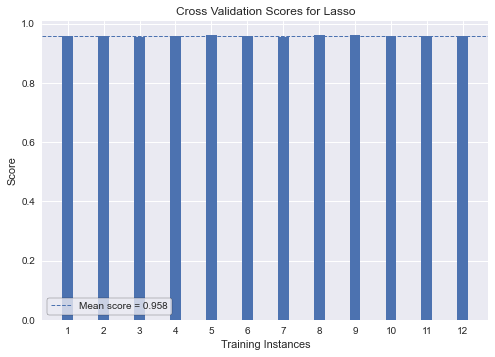

<AxesSubplot:title={'center':'Cross Validation Scores for Lasso'}, xlabel='Training Instances', ylabel='Score'>

In [39]:
# Instantiate the regression model and visualizer
cv = KFold(n_splits=12, shuffle=True, random_state=42)

model_ls = Lasso()
visualizer = CVScores(model_ls, cv=cv, scoring='r2')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()  

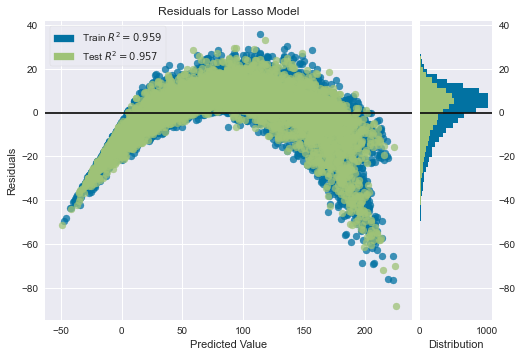

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [41]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

X2 = data.drop(columns=['calorie', 'height','weight','body_temp','female','male'], axis=1)
y2 = data.calorie     

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

# Instantiate the linear model and visualizer
model_ls2 = Lasso(alpha=0)
visualizer = ResidualsPlot(model_ls2)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

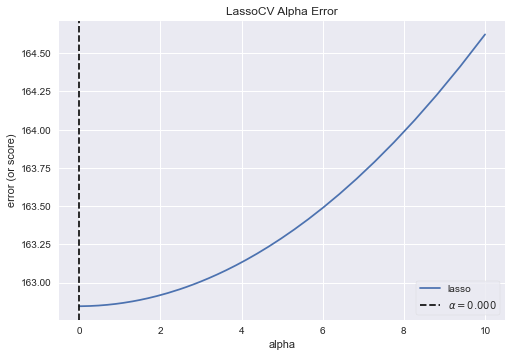

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [42]:
import numpy as np

from sklearn.linear_model import LassoCV
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection


# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 400)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X, y)
visualizer.show()

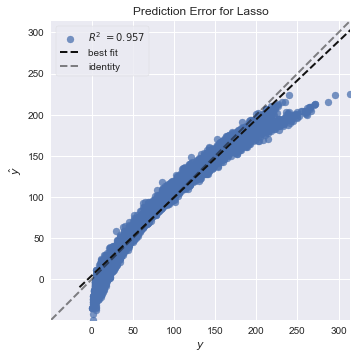

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [43]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import PredictionError

visualizer2 = PredictionError(Lasso())
visualizer2.fit(X_train, y_train)
visualizer2.score(X_test, y_test)
visualizer2.show()

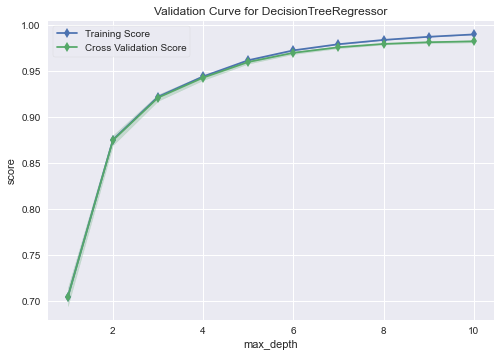

<AxesSubplot:title={'center':'Validation Curve for DecisionTreeRegressor'}, xlabel='max_depth', ylabel='score'>

In [44]:
import numpy as np

from yellowbrick.datasets import load_energy
from yellowbrick.model_selection import ValidationCurve

from sklearn.tree import DecisionTreeRegressor

# Load a regression dataset
X3 = data.drop(columns=['calorie', 'height','weight','body_temp','female','male'], axis=1)
y3 = data.calorie   

viz = ValidationCurve(
    DecisionTreeRegressor(), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X3,y3)
viz.show()

In [45]:
# Load a regression dataset
X4 = data.drop(columns=['calorie', 'height','weight','age','female','male'], axis=1)
y4 = data.calorie 

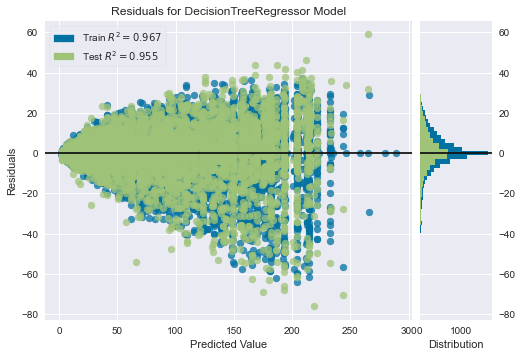

<AxesSubplot:title={'center':'Residuals for DecisionTreeRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [46]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot
   

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size=0.3, random_state=42)

# Instantiate the linear model and visualizer
model_dec = DecisionTreeRegressor(max_depth=9)
visualizer = ResidualsPlot(model_dec)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [47]:
df = df_db.copy()

In [48]:
df = df.drop(columns=['user_id'], axis=1)

In [49]:
X = df.drop(columns=['calorie'], axis=1)
y = df.calorie

In [50]:
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset

ohe = OneHotEncoder()
transformed = ohe.fit_transform(X[['gender']])
print(transformed.toarray())

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [51]:
print(ohe.categories_)

[array(['female', 'male'], dtype=object)]


In [52]:
df[ohe.categories_[0]] = transformed.toarray()

In [53]:
df = df.drop(columns=['gender'], axis=1)

In [54]:
df.head(2)

,age,height,weight,duration,heart_rate,body_temp,calorie,female,male
0,68,190.0,94.0,29.0,105.0,40.8,231.0,0.0,1.0
1,20,166.0,60.0,14.0,94.0,40.3,66.0,1.0,0.0


In [55]:
X = df.drop(columns=['calorie'], axis=1)
y = df.calorie

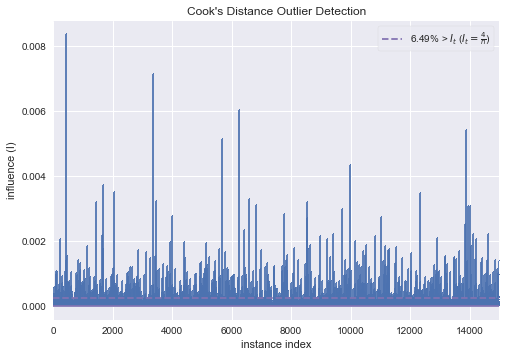

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [56]:
from yellowbrick.regressor import CooksDistance
from yellowbrick.datasets import load_concrete


# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.show()

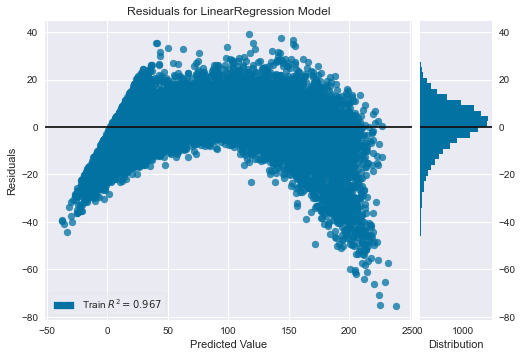

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [57]:
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot

# Instantiate and fit the visualizer
model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X, y)
visualizer_residuals.show()

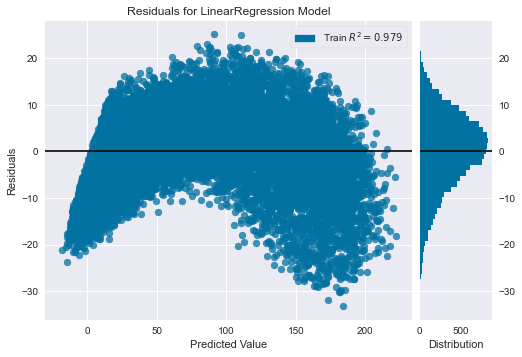

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [58]:
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_li, y_li = X[i_less_influential], y[i_less_influential]

model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X_li, y_li)
visualizer_residuals.show()

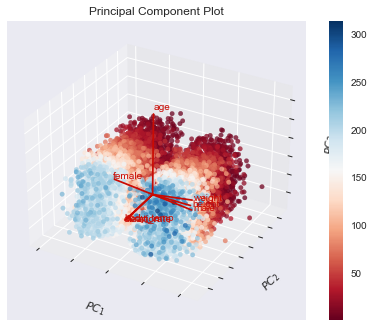

<Axes3DSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [59]:
from yellowbrick.datasets import load_concrete
from yellowbrick.features import PCA



visualizer = PCA(scale=True, proj_features=True, projection=3)
visualizer.fit_transform(X, y)
visualizer.show()